In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
import xgboost as xgb
import math
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import scipy.stats as stats

In [2]:
df = pd.read_csv('credit_risk.csv')
df

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,49,0,2,1,3782.410356,0,1,1
1,0,62,1,3,1,11516.000660,0,1,1
2,0,43,1,2,1,1746.632495,1,1,1
3,0,59,0,0,0,1195.975234,1,1,1
4,0,58,1,4,1,7217.466097,0,1,1
...,...,...,...,...,...,...,...,...,...
13977,0,36,1,2,1,6856.358688,0,1,0
13978,0,44,0,0,1,2245.684172,0,1,0
13979,0,47,0,1,1,14793.528320,0,1,1
13980,0,62,0,0,1,2118.337362,0,1,1


In [3]:
# create summary table
df_summary = df.describe().T
df_summary.index = df_summary.index.str.replace('_','\_',regex=True)
df_summary.to_latex('table/data_description.tex',columns=['count','mean','std','min','max'],float_format="%.2f",bold_rows=True, caption='Data Description', label='tab:data_description',position='centering')

In [4]:
default_rate = df['default_label'].sum() / len(df)
print(f'The default rate of sample is {default_rate:.2%}')

The default rate of sample is 2.20%


In [5]:
# plots the roc curve based of the probabilities
def plot_roc_curve(true_y, y_prob, model_name):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {model_name} (AUC={auc:.2f})')
    plt.savefig(f'./fig/roc_curve_{model_name}.png')

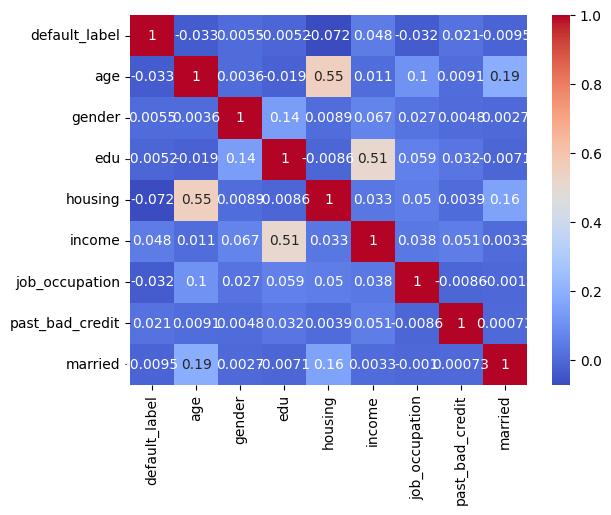

In [9]:
# Plot heatmap
# sns.heatmap(df.drop(columns=['default_label']).corr(), annot=True, cmap='coolwarm')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Save the heatmap as an image
plt.savefig('fig/variable_heatmap.png')


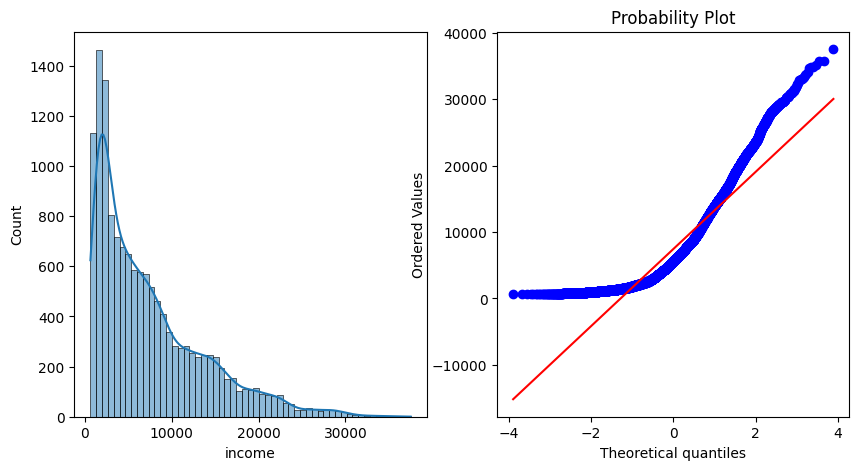

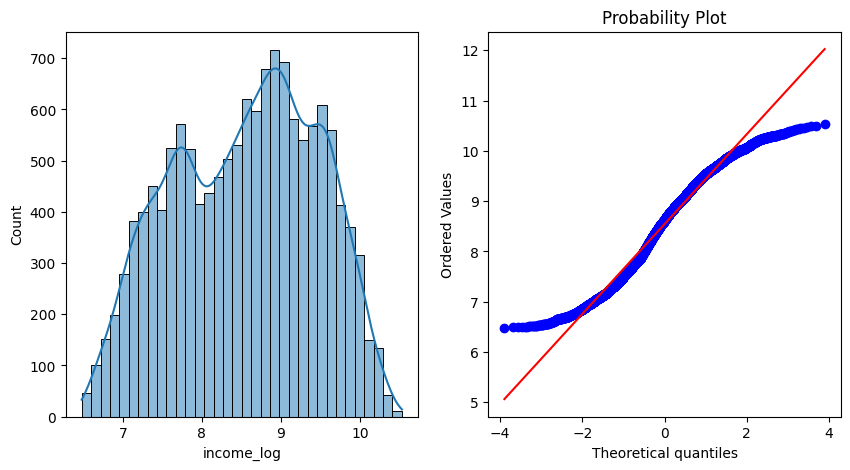

In [18]:
## Transformation of skewed variables
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution.png')

# Log transformation
logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), ['income'])])
df['income_log'] = logTr.fit_transform(df)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income_log'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income_log'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution_log_transform.png')


# Feature selection

# Simple Logistic Model

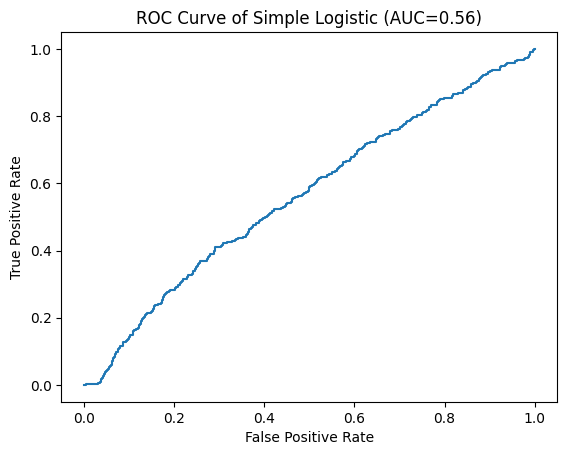

In [29]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income']])

plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income']])[:,1],'Simple Logistic')

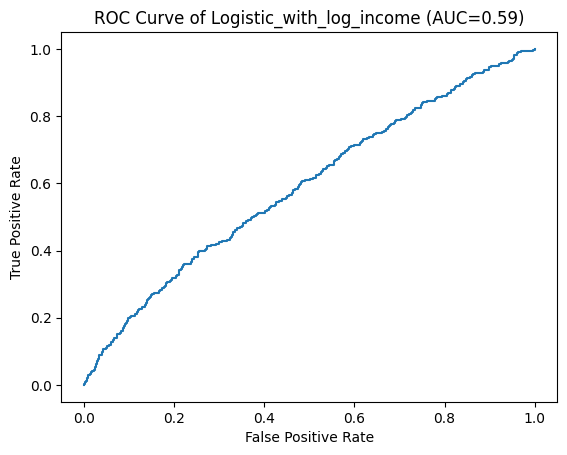

In [31]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income_log']])
plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income_log']])[:,1],'Logistic_with_log_income')

# Full Logistic Model

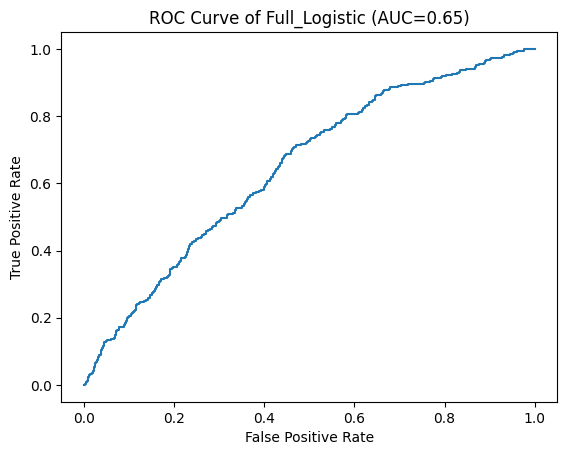

In [34]:
mod = LogisticRegressionCV()
X=df.drop(columns=['default_label','income_log'])
rres = mod.fit(y = df['default_label'], X=X)
plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'Full_Logistic')

# SVM/ Random Forest

## SVM

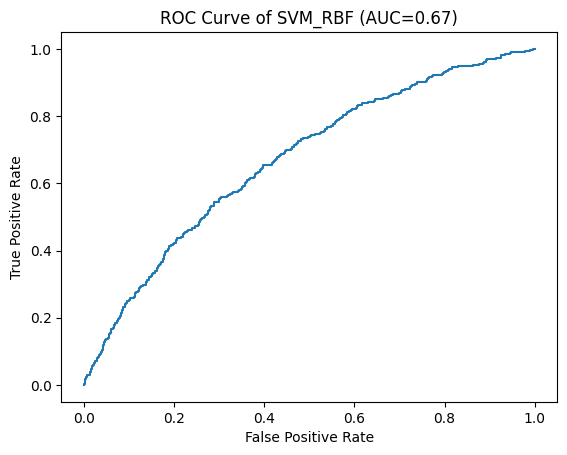

In [38]:
# SVM using RBF kernel
X=df.drop(columns=['default_label','income'])
mod = svm.SVC(class_weight='balanced',kernel='rbf', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_RBF')

SVM with sigmoid kernal AUC: 0.4397776422787393


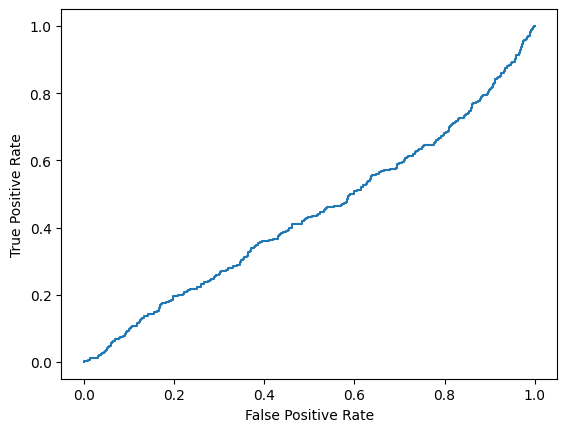

In [20]:
# kernel SVM
mod = svm.SVC(class_weight='balanced',kernel='sigmoid', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
default_label_pred = mod.predict(X)
plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1])

true_labels = df['default_label']
predicted_probabilities = mod.predict_proba(X)[:, 1]
auc_sigmoidsvm = roc_auc_score(true_labels, predicted_probabilities)
print(f"SVM with sigmoid kernal AUC: {auc_sigmoidsvm}")

SVM with poly kernel AUC: 0.5804809677670582


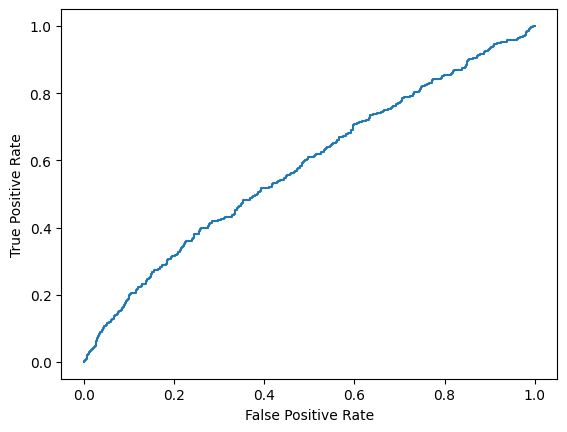

In [21]:
# polynomial kernel SVM
mod = svm.SVC(class_weight='balanced',kernel='poly', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
default_label_pred = mod.predict(X)
plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1])

true_labels = df['default_label']
predicted_probabilities = mod.predict_proba(X)[:, 1]
auc_polysvm = roc_auc_score(true_labels, predicted_probabilities)
print(f"SVM with poly kernel AUC: {auc_polysvm}")

# Out-of-Sample Test

In [40]:
df_train = df[:10000]
df_test = df[10001:]
y = df_train['default_label']
X = df_train.drop(columns=['default_label','income'])
X_test = df_test.drop(columns=['default_label','income'])
y_test = df_test['default_label']

## Logistic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


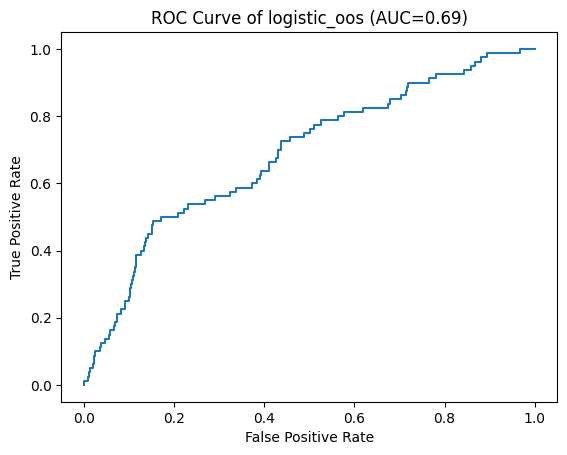

In [42]:
# Create a logistic regression model
logreg = LogisticRegression()
# Fit the model on the training data
logreg.fit(X, y)

# Plot the ROC curve
plot_roc_curve(y_test, logreg.predict_proba(X_test)[:,1],'logistic_oos')


## SVM

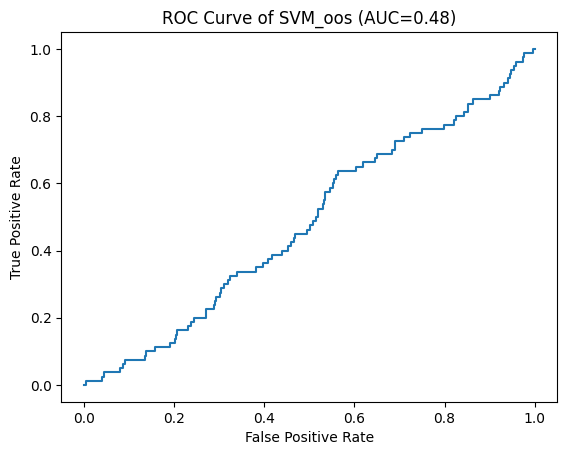

In [44]:
mod = svm.SVC(kernel='rbf', probability=True)
rres = mod.fit(y = y, X=X)
plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'SVM_oos')

## Random Forest

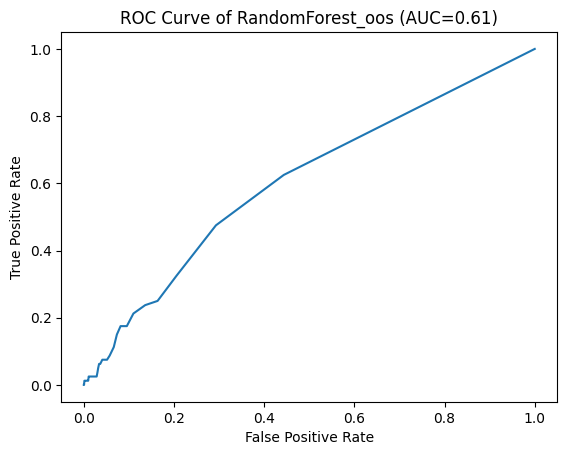

In [45]:
mod = RandomForestClassifier()
rres = mod.fit(y = y, X=X)
plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'RandomForest_oos')



## XGBoosting
Wu, W. (2022) Machine Learning Approaches to Predict Loan Default. Intelligent Information Management, 14, 157-164. doi: 10.4236/iim.2022.145011.


XGBoosting Out-of-Sample AUC: 0.5668258138938733


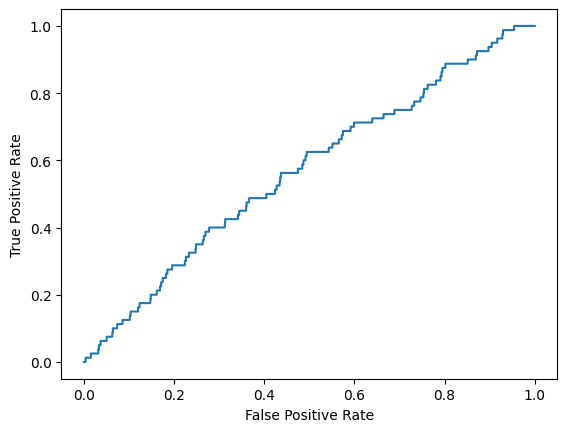

In [29]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X, y)

# Make predictions on the testing data
xgb_predictions = xgb_model.predict(X_test)

# # Print the accuracy score
# accuracy = accuracy_score(y_test, xgb_predictions)
# print(f"Accuracy: {accuracy}")

# Plot the ROC curve
default_label_pred = xgb_model.predict(X_test)
plot_roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

# Print AUC
true_labels = df_test['default_label']
predicted_probabilities = xgb_model.predict_proba(X_test)[:, 1]
auc_XGBoostingoos = roc_auc_score(true_labels, predicted_probabilities)
print(f"XGBoosting Out-of-Sample AUC: {auc_XGBoostingoos}")

## Neural Network

@article{cite-key,
	abstract = {Default prediction is the primary goal of credit risk management. This problem has long been tackled using well-established statistical classification models. Still, nowadays, the availability of large datasets and cheap software implementations makes it possible to employ machine learning techniques. This paper uses a large sample of small Italian companies to compare the performance of various machine learning classifiers and a more traditional logistic regression approach. In particular, we perform feature selection, use the algorithms for default prediction, evaluate their accuracy, and find a more suitable threshold as a function of sensitivity and specificity. Our outcomes suggest that machine learning is slightly better than logistic regression. However, the relatively small performance gain is insufficient to conclude that classical statistical classifiers should be abandoned, as they are characterized by more straightforward interpretation and implementation.},
	author = {Bazzana, Flavio and Bee, Marco and Hussin Adam Khatir, Ahmed Almustfa},
	date = {2023/11/15},
	date-added = {2024-04-18 21:22:55 +0800},
	date-modified = {2024-04-18 21:22:55 +0800},
	doi = {10.1057/s41283-023-00132-2},
	id = {Bazzana2023},
	isbn = {1743-4637},
	journal = {Risk Management},
	number = {1},
	pages = {1},
	title = {Machine learning techniques for default prediction: an application to small Italian companies},
	url = {https://doi.org/10.1057/s41283-023-00132-2},
	volume = {26},
	year = {2023},
	bdsk-url-1 = {https://doi.org/10.1057/s41283-023-00132-2}}


Neural Network Out-of-Sample AUC: 0.3883395283260702


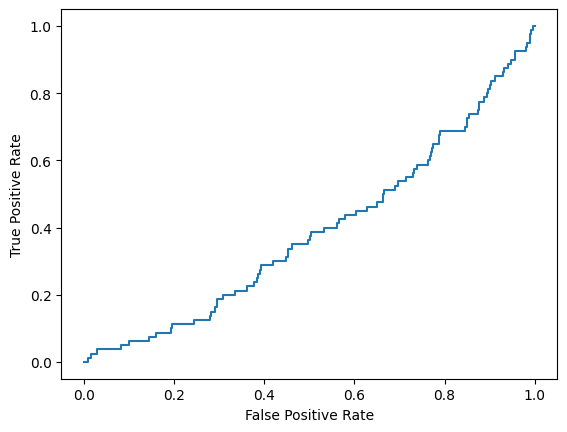

In [59]:
mod = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
rres = mod.fit(y = y, X=X)
default_label_pred = mod.predict(X_test)
plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1])
predicted_probabilities = mod.predict_proba(X_test)[:, 1]
auc_neural = roc_auc_score(true_labels, predicted_probabilities)
print(f"Neural Network Out-of-Sample AUC: {auc_neural}")